In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, cholesky

np.random.seed(0)

In [2]:
def get_radar(xpos_pred):
    """Return Predicted Horizontal Distance and Measured Distance by Radar."""
    xvel_w = np.random.normal(0, 5)   # xvel_w: system noise of horizontal velocity [m/s].
    xvel_true = 100 + xvel_w          # xvel_true: true horizontal velocity [m/s].

    ypos_w = np.random.normal(0, 10)  # ypos_w: system noise of vertical position [m].
    ypos_true = 1000 + ypos_w         # ypos_true: true vertical position [m].

    xpos_pred = xpos_pred + xvel_true * dt                     # xpos_pred: predicted horizontal distance [m].

    rpos_v = xpos_pred * np.random.normal(0, 0.05)             # rpos_v: measurment noise of distance from radar.
    rpos_meas = np.sqrt(xpos_pred**2 + ypos_true**2) + rpos_v  # r: measured distance [m] (observable).

    return rpos_meas, xpos_pred

In [3]:
def sigma_points(mu, Sigma, kappa):
    n = len(mu)
    Xi = np.zeros((n, 2*n+1))
    W = np.zeros(2*n+1)
    
    Xi[:, 0] = mu
    W[0] = kappa / (n + kappa)
    
    U = cholesky((n + kappa)*Sigma)
    
    for i in range(n):
        Xi[:, i+1]   = mu + U[:, i]
        Xi[:, n+i+1] = mu - U[:, i]
        W[i+1]       = 1 / (2*(n+kappa))
        W[n+i+1]     = W[i+1]
        
    return Xi, W

In [4]:
def UT(Xi, W, noiseCov):
    mean = np.sum(W * Xi, axis=1)
    cov = W * (Xi - mean.reshape(-1, 1)) @ (Xi  - mean.reshape(-1, 1)).T
    return mean, cov + noiseCov

In [5]:
def fx(x_esti):
    return A @ x_esti

def hx(x_pred):
    z_pred = np.sqrt(x_pred[0]**2 + x_pred[2]**2)
    return np.array([z_pred])

In [6]:
def unscented_kalman_filter(z_meas, x_esti, P):
    """Unscented Kalman Filter Algorithm."""
    # (1) Sample Sigma Points and Weights.
    Xi, W = sigma_points(x_esti, P, kappa)

    # (2) Predict Mean and Error Covariance of States.
    fXi = fx(Xi)
    x_pred, P_x = UT(fXi, W, Q)

    # (3) Calculate Mean and Error Covariance for the Expected Observation.
    hXi = hx(fXi)
    z_pred, P_z = UT(hXi, W, R)

    # (4) Calculate Off Diagonal Elements of Error Covariance and Kalman Gain.
    Pxz = W * (fXi - x_pred.reshape(-1, 1)) @ (hXi - z_pred.reshape(-1, 1)).T
    K = Pxz @ inv(P_z)

    # (5) Estimate Mean and Error Covariance of States. 
    x_esti = x_pred + K @ (z_meas - z_pred)
    P = P_x - K @ P_z @ K.T

    return x_esti, P

In [7]:
# Input parameters.
time_end = 20
dt = 0.05

In [8]:
# Initialization for system model.
# Matrix: A, H, Q, R, P_0
# Vector: x_0
A = np.eye(3) + dt * np.array([[0, 1, 0],
                               [0, 0, 0],
                               [0, 0, 0]])
Q = np.array([[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]])
R = np.array([[100]])

# Initialization for estimation.
x_0 = np.array([0, 90, 1100])  # [horizontal position, horizontal velocity, vertical position].
P_0 = 100 * np.eye(3)

# Initialization for sigma points.
kappa = 0

In [9]:
time = np.arange(0, time_end, dt)
n_samples = len(time)
xpos_esti_save = np.zeros(n_samples)
ypos_esti_save = np.zeros(n_samples)
rpos_esti_save = np.zeros(n_samples)
xvel_esti_save = np.zeros(n_samples)
rpos_meas_save = np.zeros(n_samples)

In [10]:
xpos_pred = 0
x_esti, P = None, None
for i in range(n_samples):
    z_meas, xpos_pred = get_radar(xpos_pred)
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = unscented_kalman_filter(z_meas, x_esti, P)

    xpos_esti_save[i] = x_esti[0]
    ypos_esti_save[i] = x_esti[2]
    rpos_esti_save[i] = np.sqrt(x_esti[0]**2 + x_esti[2]**2)
    xvel_esti_save[i] = x_esti[1]
    rpos_meas_save[i] = z_meas

Text(0, 0.5, 'Horizontal Velocity [m/s]')

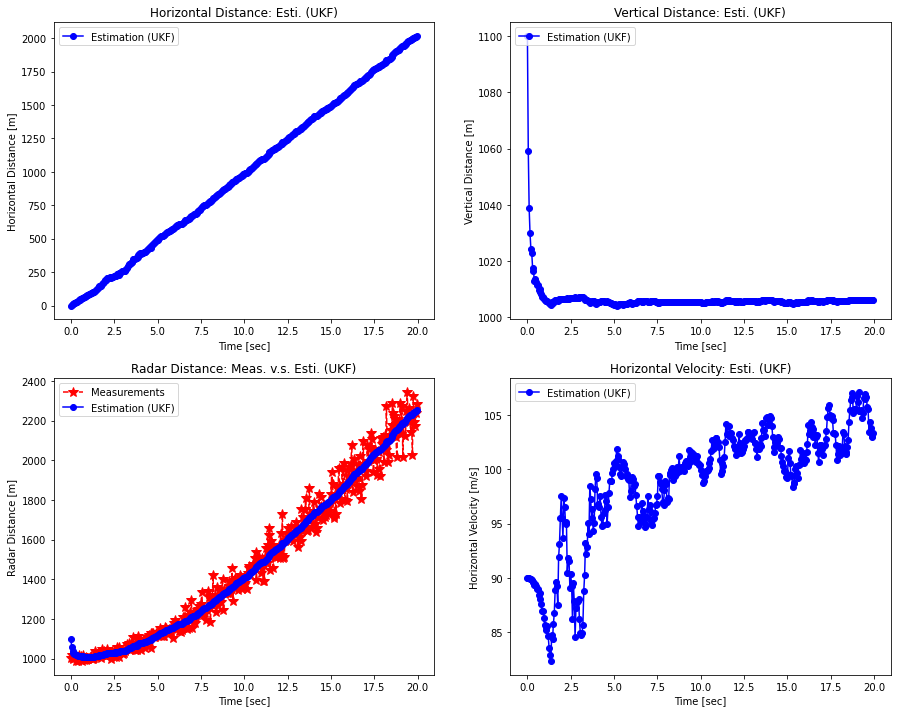

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

axes[0, 0].plot(time, xpos_esti_save, 'bo-', label='Estimation (UKF)')
axes[0, 0].legend(loc='upper left')
axes[0, 0].set_title('Horizontal Distance: Esti. (UKF)')
axes[0, 0].set_xlabel('Time [sec]')
axes[0, 0].set_ylabel('Horizontal Distance [m]')

axes[0, 1].plot(time, ypos_esti_save, 'bo-', label='Estimation (UKF)')
axes[0, 1].legend(loc='upper left')
axes[0, 1].set_title('Vertical Distance: Esti. (UKF)')
axes[0, 1].set_xlabel('Time [sec]')
axes[0, 1].set_ylabel('Vertical Distance [m]')

axes[1, 0].plot(time, rpos_meas_save, 'r*--', label='Measurements', markersize=10)
axes[1, 0].plot(time, rpos_esti_save, 'bo-', label='Estimation (UKF)')
axes[1, 0].legend(loc='upper left')
axes[1, 0].set_title('Radar Distance: Meas. v.s. Esti. (UKF)')
axes[1, 0].set_xlabel('Time [sec]')
axes[1, 0].set_ylabel('Radar Distance [m]')

axes[1, 1].plot(time, xvel_esti_save, 'bo-', label='Estimation (UKF)')
axes[1, 1].legend(loc='upper left')
axes[1, 1].set_title('Horizontal Velocity: Esti. (UKF)')
axes[1, 1].set_xlabel('Time [sec]')
axes[1, 1].set_ylabel('Horizontal Velocity [m/s]')